# Procesamiento de imágenes · Tarea 7

¡Bienvenidos a la ultima tarea del curso! En esta aprenderemos sobre detección de bordes, implementaremos nuevas técnicas de _thresholding_ y veremos un ejemplo de MSER.

### Importante
* Lee atentamente las instrucciones y todo el código.
* Ejecuta las celdas en orden.
* Escribe tu código en las celdas que lo soliciten.
* Usa los nombres de variables que te pidan.
* Confirma que tu código esté correcto corriendo las celdas que dicen "Chequeo".
* Si el chequeo alerta que hay alguna variable incorrecta, vuelve atrás y arréglala. No hay penalización por esto.

## Configuración inicial

##### Importamos librerías

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

#import checker
import importlib

##### Aumentamos el tamaño de las imágenes

In [2]:
plt.rcParams['figure.dpi'] = 200

## Parte 1 ·  Detección de bordes

Detectar los bordes de un objeto nos permite visualizarlo de una manera distinta, pudiendo extraer propiedades y características de su estructura.

A continuación trabajaremos con una foto de un tomate. Encontraremos sus bordes usando LoG y Canny.

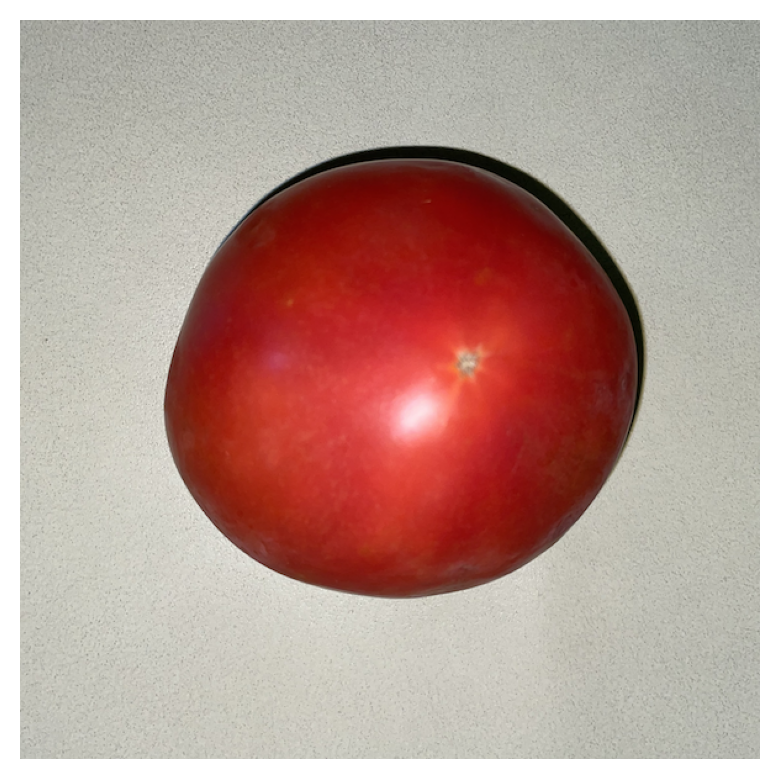

In [3]:
img_tomato_path = 'tomato.png'
img_tomato_color = cv2.imread(img_tomato_path, cv2.IMREAD_COLOR)
img_tomato_gray = cv2.imread(img_tomato_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(img_tomato_color[:, :, ::-1], cmap='gray')
plt.axis('off');

El primer paso del algoritmo LoG es aplicarle un filtro Gaussiano a la imagen.

Usa la función ```GaussianBlur``` de OpenCV para suavizar ```img_tomato_gray```. Usa ```sigma``` igual a 2 y ```ksize``` igual a ```(0, 0)``` para que su valor se calcule automáticamente. Guarda el resultado en ```img_tomato_gaussian```.

In [4]:
# Escribe tu código en las siguientes líneas
sigma = 2
img_tomato_gaussian = cv2.GaussianBlur(img_tomato_gray, (0, 0), sigma)

##### Chequeo

importlib.reload(checker)
assert checker.check_img_tomato_gaussian(img_tomato_gaussian)

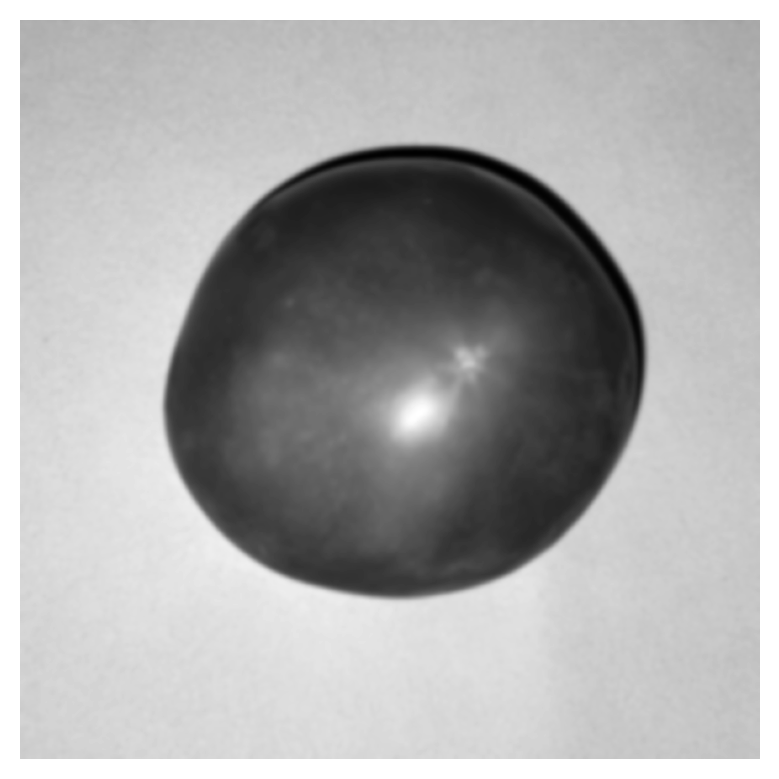

In [5]:
plt.imshow(img_tomato_gaussian, cmap='gray')
plt.axis('off');

Excelente, has filtrado la imagen.

Ahora debemos calcular el Laplaciano de ```img_tomato_gaussian```. Usa la función ```Laplacian``` de OpenCV con ```ddepth``` igual a  ```cv2.CV_16S``` y ```ksize``` igual a 3. Guarda el resultado en ```img_tomato_borders_log```.

In [6]:
# Escribe tu código en las siguientes líneas
img_tomato_borders_log = cv2.Laplacian(img_tomato_gaussian, ddepth=cv2.CV_16S, ksize=3)

##### Chequeo

importlib.reload(checker)
assert checker.check_img_tomato_borders_log(img_tomato_borders_log)

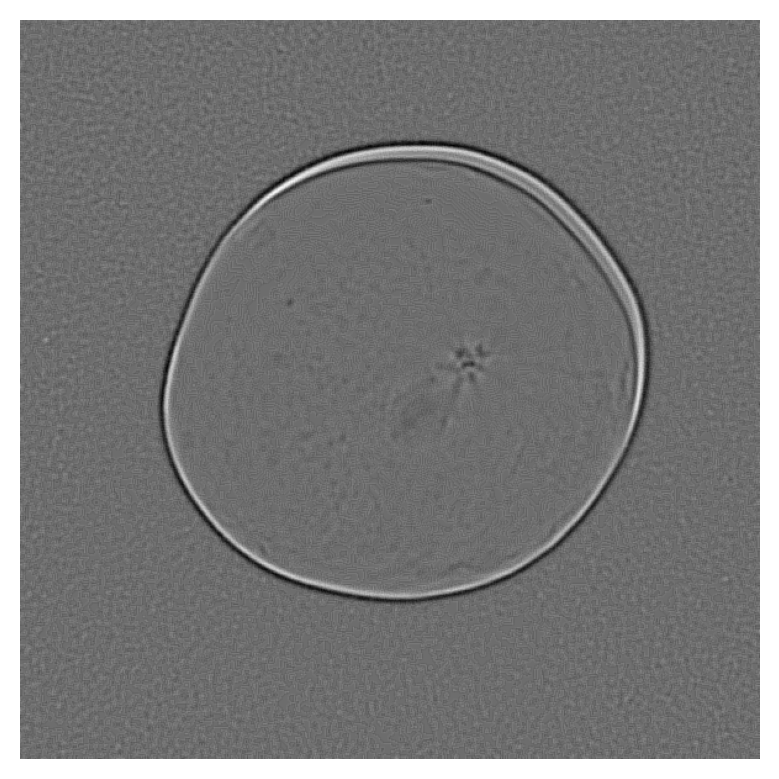

In [7]:
plt.imshow(img_tomato_borders_log, cmap='gray')
plt.axis('off');

Tenemos el Laplaciano del Gaussiano. Vemos que en los bordes del tomate hay cruces por cero con una gran pendiente.

El siguiente paso debería ser encontrar los cruces por cero de ```img_tomato_borders_log```. Sin embargo, debido a la baja complejidad de la foto podemos obtener los bordes de una manera más simple: aplicándole un umbral global.

In [8]:
img_tomato_borders_log_bin = (img_tomato_borders_log > 10).astype(np.uint8)

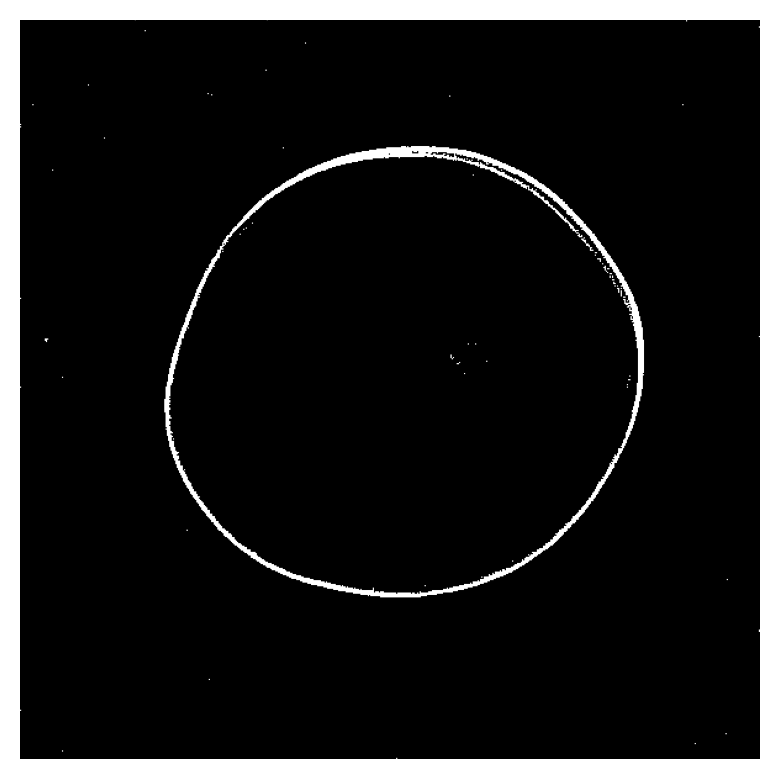

In [9]:
plt.imshow(img_tomato_borders_log_bin, cmap='gray')
plt.axis('off');

Hemos encontrado los bordes del tomate con solo tres líneas de código. El resultado no es perfecto, pero para ciertas aplicaciones es suficientemente bueno. Este se podría mejorar encontrando los cruces por cero en vez de usando un umbral simple.

Veamos cómo quedan los bordes al aplicar el algoritmo de Canny. Comenzando con ```img_tomato_gray```, aplica la función ```Canny``` de OpenCV con los umbrales 200 y 600. Guarda el resultado en ```img_tomato_borders_canny```.

In [12]:
# Escribe tu código en las siguientes líneas
img_tomato_borders_canny = cv2.Canny(img_tomato_gray, 200, 600)

##### Chequeo

importlib.reload(checker)
assert checker.check_img_tomato_borders_canny(img_tomato_borders_canny)

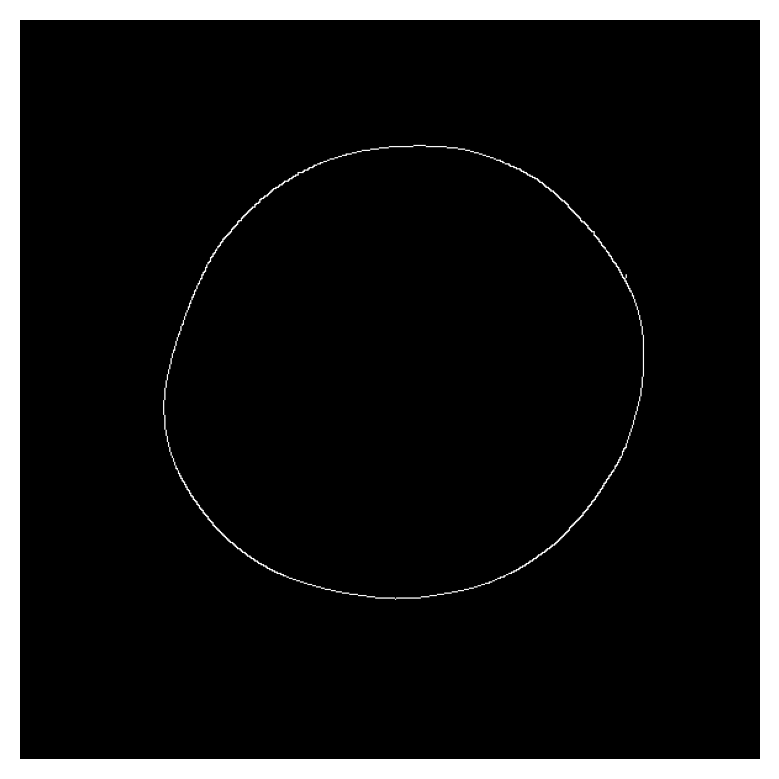

In [13]:
plt.imshow(img_tomato_borders_canny, cmap='gray')
plt.axis('off');

El resultado usando Canny y los parámetros escogidos es perfecto. Obtuvimos una imagen binaria donde el borde es representado como una línea contínua de ancho unitario.

Ahora que tenemos el borde del objeto podemos aplicarle un algoritmo de _region growing_ para obtener toda su región.

In [14]:
import cv2
import scipy.ndimage

def region_growing(img, seed_coords):
    mask = np.zeros(img.shape)
    mask[seed_coords] = 1
    old_mask = np.zeros(img.shape, dtype=np.uint8)
    while not np.array_equal(old_mask, mask):
        old_mask = mask.copy()
        mask = scipy.ndimage.binary_dilation(mask)
        mask = np.logical_and(mask, np.logical_not(img))
    mask = mask.astype(np.uint8)
    return mask

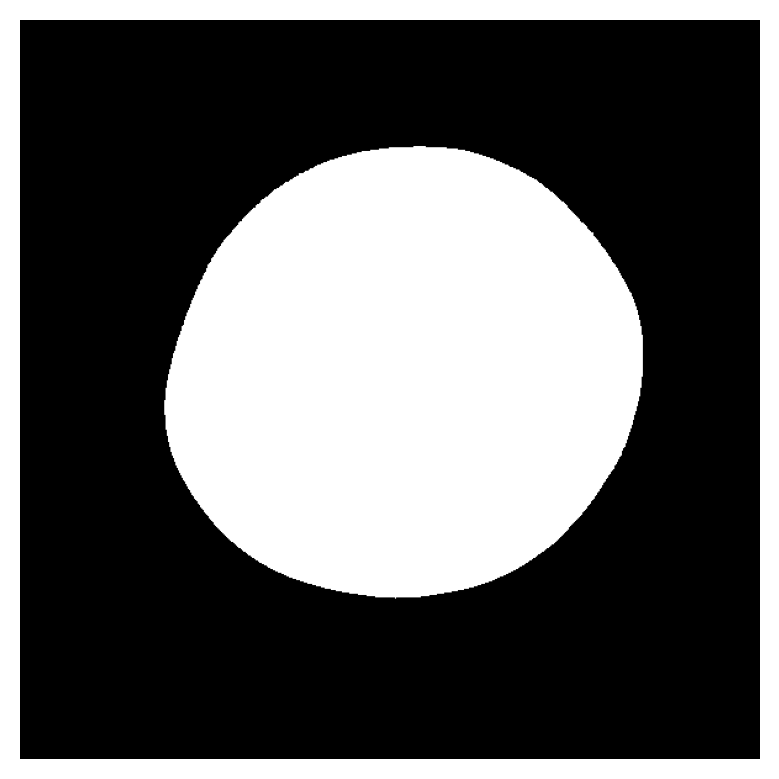

In [15]:
mask_tomato_canny = region_growing(img_tomato_borders_canny, (300, 300))

plt.imshow(mask_tomato_canny, cmap='gray')
plt.axis('off');

La máscara obtenida es perfecta. Ahora la podemos usar para segmentar el objeto de interés.

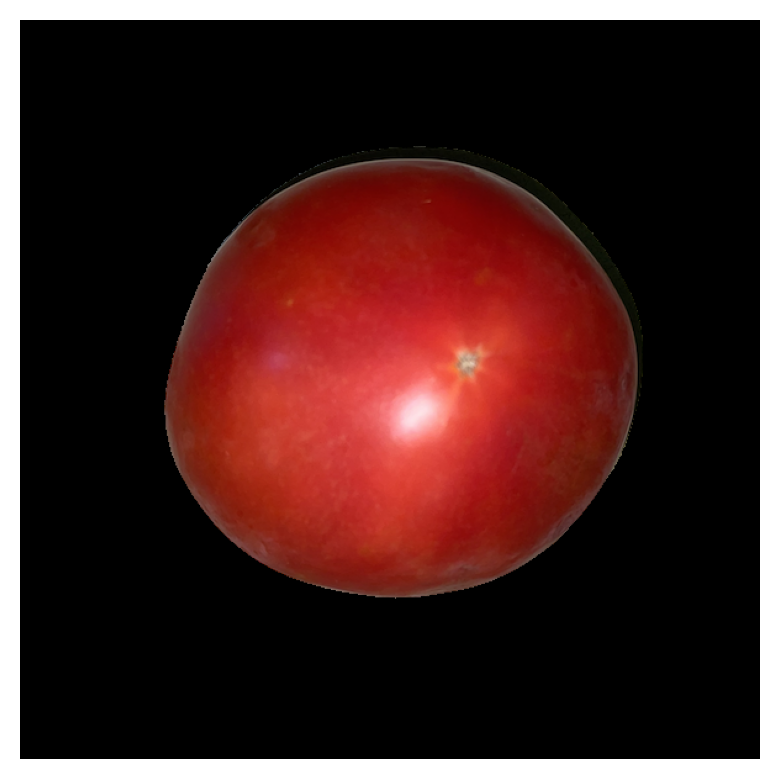

In [16]:
img_tomato_masked = cv2.bitwise_and(img_tomato_color, img_tomato_color, mask=mask_tomato_canny)

plt.subplot(1, 1, 1)
plt.imshow(img_tomato_masked[:, :, ::-1])
plt.axis('off');

¡Logramos segmentar el tomate a partir de sus bordes!

## Parte 2 ·  Thresholding

En la primera tarea de este curso trabajamos con una fotografía de un avión. Estudiamos su histograma y definimos un umbral a mano. Veamos si podemos automatizar esta selección de umbral.

In [34]:
img_plane_path = 'plane.jpg'
img_plane_gray = cv2.imread(img_plane_path, cv2.IMREAD_GRAYSCALE)

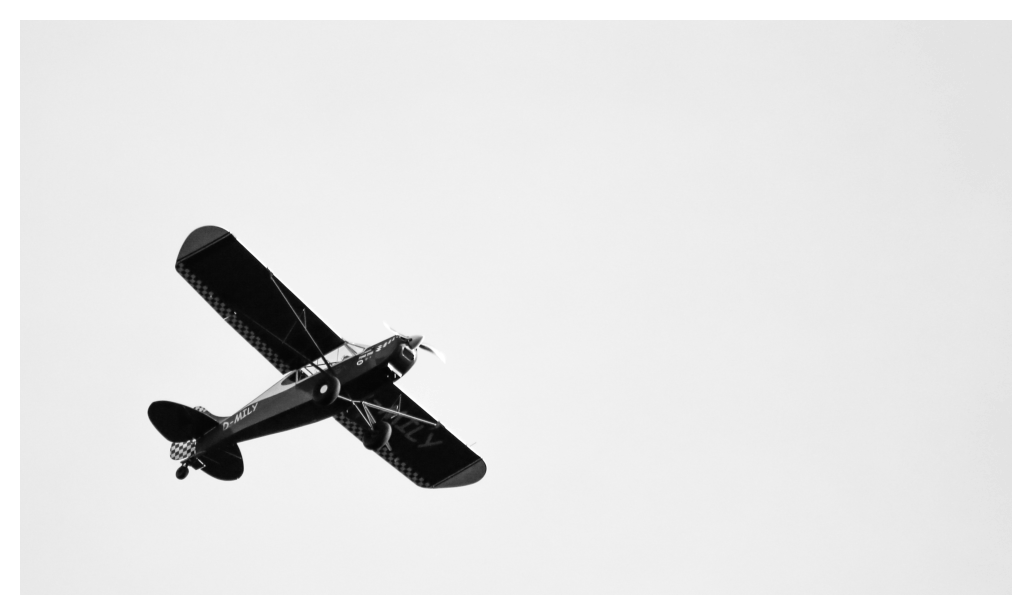

In [35]:
plt.imshow(img_plane_gray, cmap='gray')
plt.axis('off');

En clases vimos que el método de Otsu nos permite encontrar automáticamente el umbral de una imagen cuyo histograma es bimodal. Veamos cómo funciona para esta foto.

Usa la función ```threshold``` de OpenCV para segmentar ```img_plane_gray``` con el método de Otsu. Los pixeles del avión deben valer 0 y el resto 255. Guarda el umbral encontrado en ```thresh_plane_otsu``` y la imagen resultante en ```mask_plane_otsu```.

In [45]:
# Escribe tu código en las siguientes líneas
thresh_plane_otsu, mask_plane_otsu = cv2.threshold(img_plane_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

##### Chequeo

importlib.reload(checker)
assert checker.check_thresh_plane_otsu(thresh_plane_otsu)

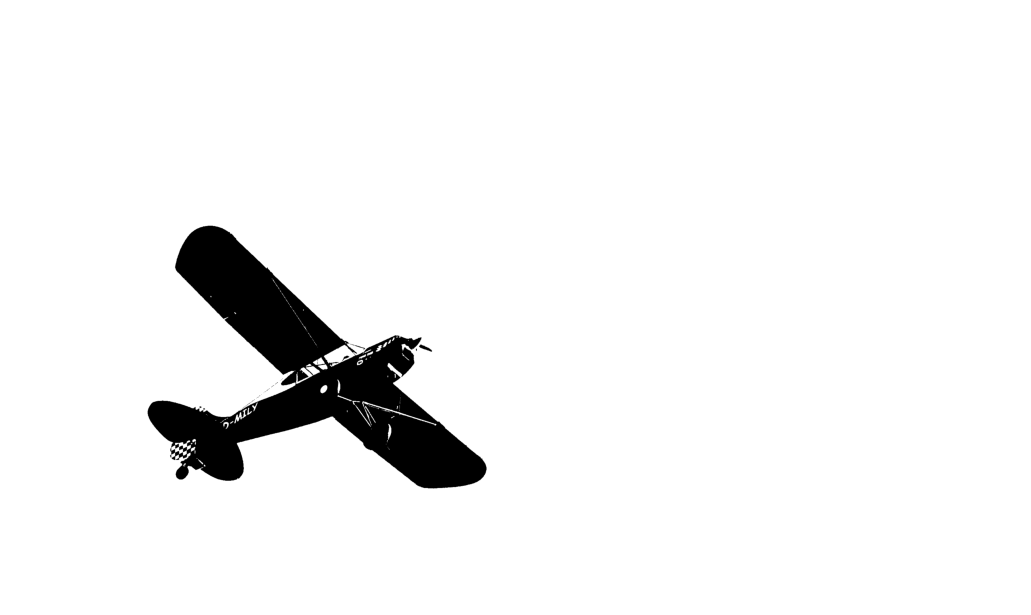

In [46]:
plt.imshow(mask_plane_otsu, cmap='gray')
plt.axis('off');

El umbral encontrado automáticamente logra extraer el avión de la imagen a la perfección.

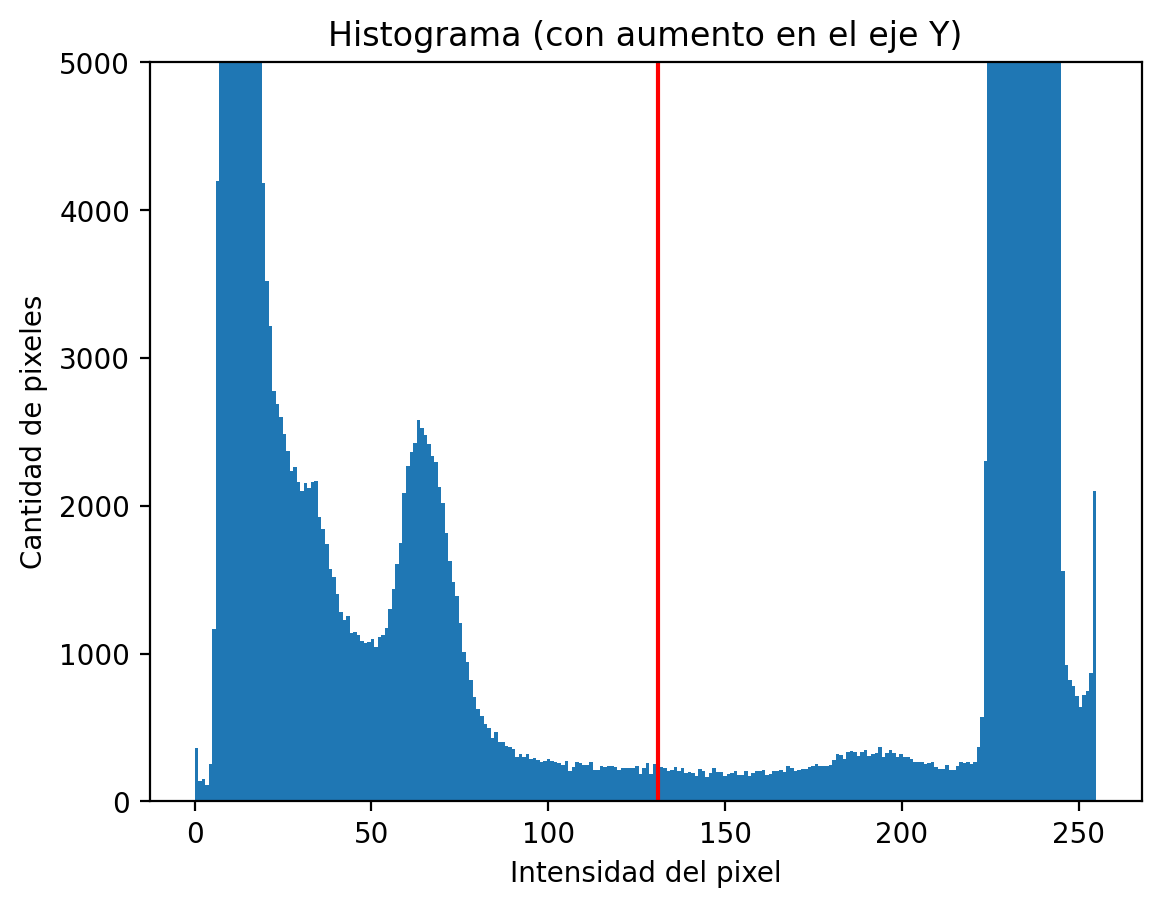

In [47]:
plt.hist(img_plane_gray.ravel(), 256)
plt.axvline(x=thresh_plane_otsu, color='red')
plt.ylim(0, 5000)
plt.title('Histograma (con aumento en el eje Y)')
plt.xlabel('Intensidad del pixel')
plt.ylabel('Cantidad de pixeles');

El método de Otsu calculó un umbral ideal entre los dos grandes _peaks_ que presenta el histograma. Este método es de gran utilidad cuando se debe encontrar el _threshold_ de varias imágenes.

### _Thresholding_ adaptativo

Existen situaciones donde un _threshold_ global no basta para segmentar adecuadamente una imagen. Por ejemplo, veamos la siguente foto de una carta.

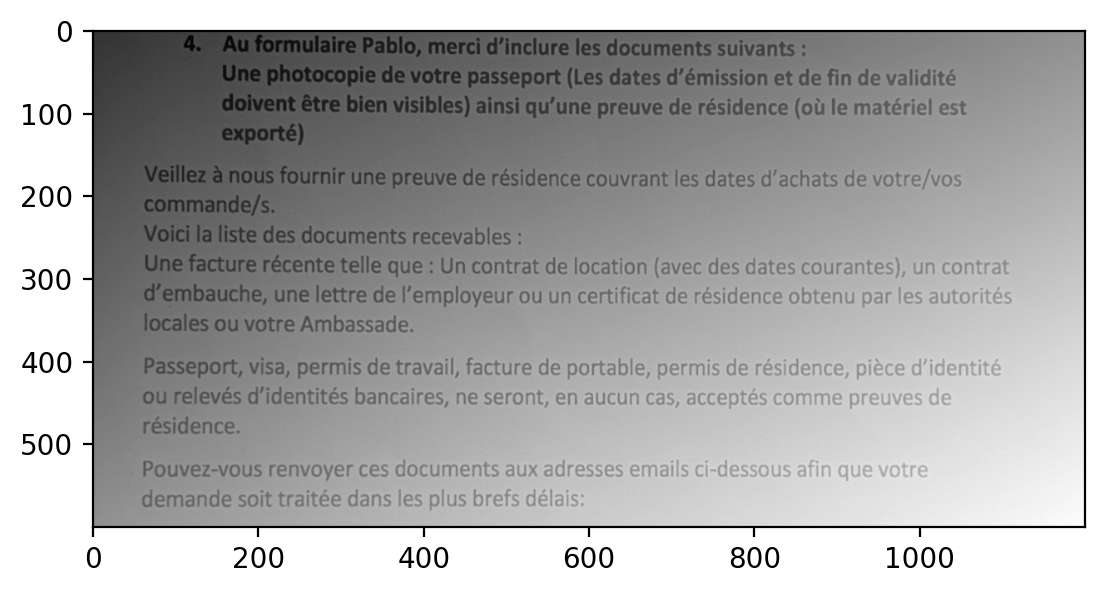

In [48]:
img_text_path = 'text.png'
img_text = cv2.imread(img_text_path, cv2.IMREAD_GRAYSCALE)

plt.imshow(img_text, cmap='gray');

La foto fue tomada con una iluminación no ideal, por lo que quedó con un gradiente sobre el texto.

Veamos qué pasa si le aplicamos un umbral global. Define ```img_text_thresh_global```, una imagen binaria que segmenta a ```img_text```, fijando en 1 a todos los valores mayores a 100 y en 0 al resto.

In [62]:
# Escribe tu código en las siguientes líneas
img_text_thresh_global = (cv2.threshold(img_text, 100, 255, cv2.THRESH_BINARY)[1] / 255).astype(np.uint8)

##### Chequeo

importlib.reload(checker)
assert checker.check_img_text_thresh_global(img_text_thresh_global)

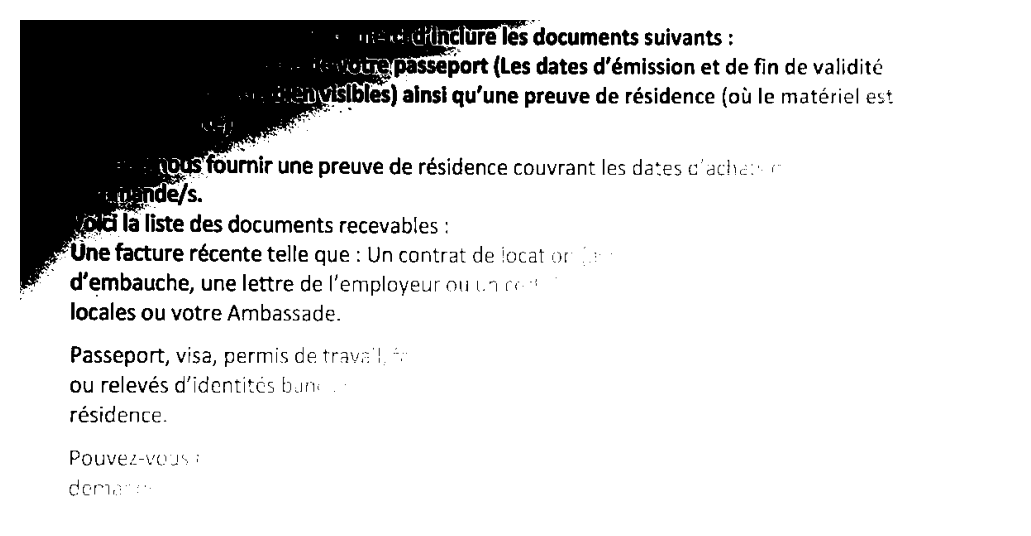

In [63]:
plt.imshow(img_text_thresh_global, cmap='gray')
plt.axis('off');

Claramente, un umbral global no permite segmentar adecuadamente el texto. Probemos algo distinto.

Como el tono de gris promedio no es el mismo en distintas secciones de la imagen, una solución consiste en usar un algoritmo que aplique umbrales locales para bloques pequeños de la imagen.

Crea la función ```adaptive_threshold_otsu(img, block_size, constant)``` que segmente adaptativamente una imagen. La función tomará ```img``` y la dividirá en bloques de ```block_size``` x ```block_size```. Luego iterará sobre cada uno de estos bloques y calculará el _threshold_ óptimo con el método de Otsu. El umbral a aplicar en cada bloque debe ser ```constant``` menor al retornado por Otsu. El texto debe valer 0 y el papel 1. La imagen final debe ser la concatenación de cada uno de los bloques. 

In [66]:
# Escribe tu código en las siguientes líneas
def adaptive_threshold_otsu(img, block_size, constant):
    img_adaptive = np.zeros_like(img)

    for i in range(0, img.shape[0], block_size):
        for j in range(0, img.shape[1], block_size):
            img_block = img[i:i+block_size, j:j+block_size]
            thresh = cv2.threshold(img_block, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[0]
            img_adaptive[i:i+block_size, j:j+block_size] = (img_block > (thresh - constant)).astype(np.uint8)
    return img_adaptive

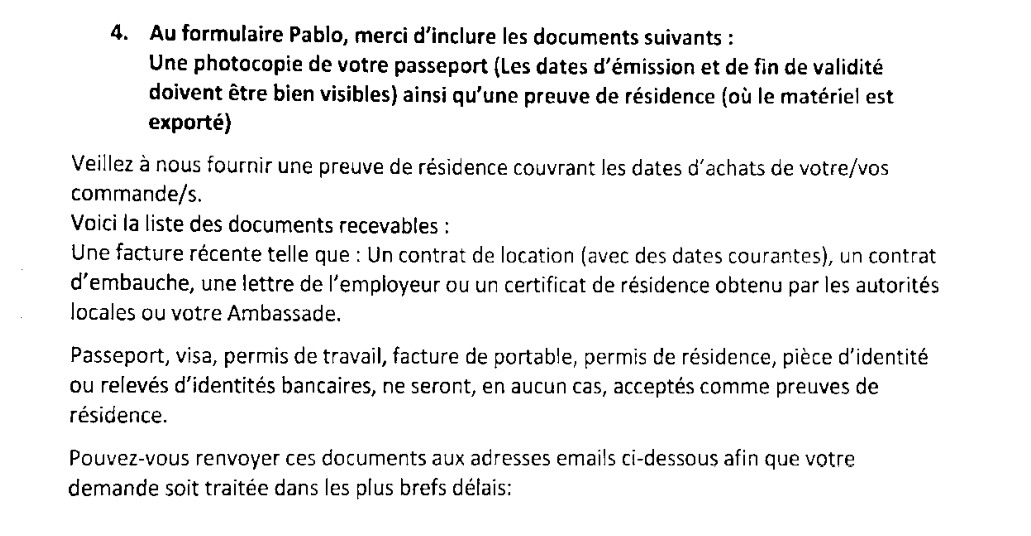

In [67]:
img_text_thresh_adaptive = adaptive_threshold_otsu(img_text, 60, 10)
plt.imshow(img_text_thresh_adaptive, cmap='gray')
plt.axis('off');

##### Chequeo

importlib.reload(checker)
assert checker.check_img_text_thresh_adaptive(img_text_thresh_adaptive)

Como el algoritmo calcula un umbral óptimo para cada bloque, obtenemos una imagen segmentada adecuadamente. 

También podemos aplicar un _thresholding_ adaptativo usando funciones de OpenCV. Segmenta ```img_text``` usando la función ```adaptiveThreshold``` de OpenCV en el modo media, con un tamaño de bloque igual a 61 y una constante igual a 10. Ahora, el texto debe valer 0 y el papel 255. Guarda el resultado en ```img_text_thresh_mean```.

[Aquí](https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html) se muestra cómo usar la función.

In [72]:
# Escribe tu código en las siguientes líneas
block_size = 61
constant = 10

img_text_thresh_mean = cv2.adaptiveThreshold(img_text, 
                                             maxValue=255, 
                                             adaptiveMethod=cv2.ADAPTIVE_THRESH_MEAN_C, 
                                             thresholdType=cv2.THRESH_BINARY,
                                             blockSize=block_size, 
                                             C=constant)

##### Chequeo

importlib.reload(checker)
assert checker.check_img_text_thresh_mean(img_text_thresh_mean)

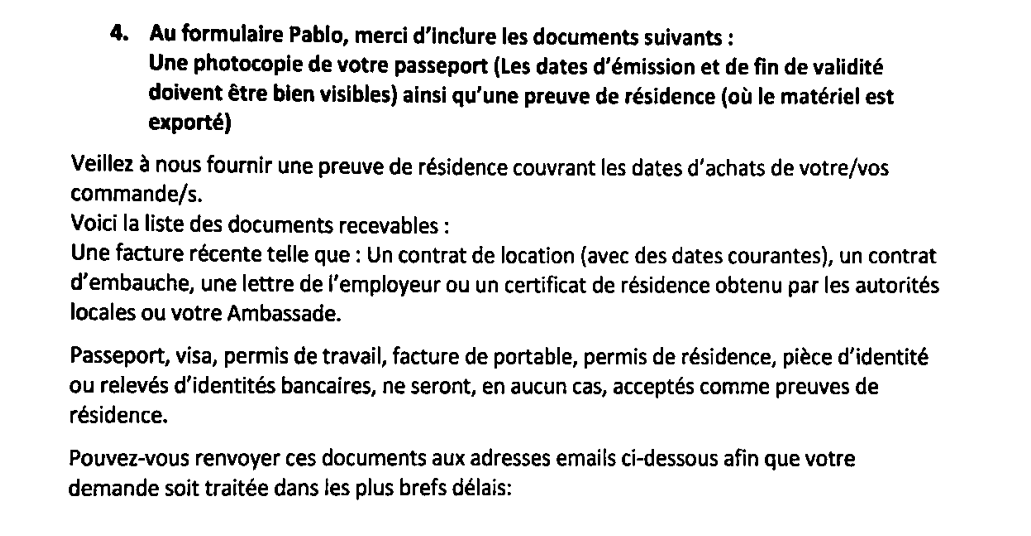

In [73]:
plt.imshow(img_text_thresh_mean, cmap='gray')
plt.axis('off');

Al igual que con la función que creaste anteriormente, se obtienen fantásticos resultados.

Probemos haciendo lo mismo pero con el modo Gaussiano. Usa los mismos parámetros que antes y guarda el resultado en ```img_text_thresh_gaussian```.

In [75]:
# Escribe tu código en las siguientes líneas
block_size = 61
constant = 10

img_text_thresh_gaussian = cv2.adaptiveThreshold(img_text, 
                                             maxValue=255, 
                                             adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                             thresholdType=cv2.THRESH_BINARY,
                                             blockSize=block_size, 
                                             C=constant)

##### Chequeo

importlib.reload(checker)
assert checker.check_img_text_thresh_gaussian(img_text_thresh_gaussian)

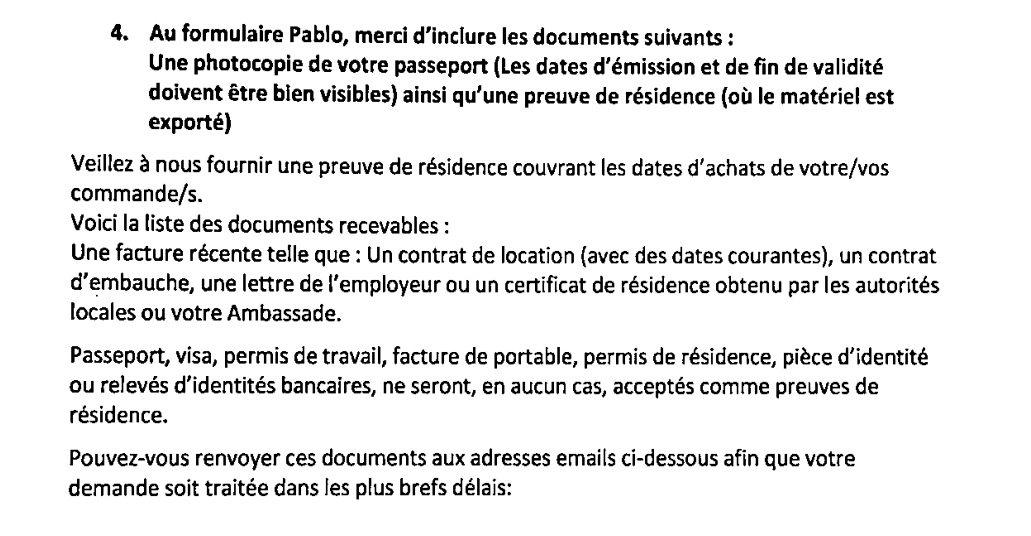

In [76]:
plt.imshow(img_text_thresh_gaussian, cmap='gray')
plt.axis('off');

Nuevamente obtenemos excelentes resultados. ¡Felicitaciones!

## Parte 3 · MSER

Existen casos donde queremos segmentar varios objetos de una imagen que tienen tonos de grises distintos. Por ejemplo, tomemos la siguiente foto:

<img src="pencilcase.png" alt="pencil case" width="400"/>

Debido a los distintos tonos de gris, los algoritmos de segmentación vistos probablemente no lograrían segmentar los objetos correctamente.

Para casos como este podemos usar el algoritmo MSER. Este nos permite identificar y segmentar los objetos individualmente, obteniendo los _bounding box_ de cada uno.

El siguiente ejemplo usa OpenCV para encontrar las regiones y los _bounding boxes_ de cada uno de los objetos. Luego se etiqueta cada objeto y se calculan sus bordes.

In [68]:
# Importamos las librerías de skimage necesarias
import skimage.measure
import skimage.morphology
import skimage.segmentation

# Cargamos la radiografía del estuche
img_pencilcase_path = 'pencilcase.png'
img_pencilcase = cv2.imread(img_pencilcase_path, cv2.IMREAD_GRAYSCALE)

# Creamos nuestro detector MSER
mser = cv2.MSER_create(
    _min_area=60,
    _max_area=40000,
    _min_diversity=0.9,
    _max_variation=0.2,
    _delta=3
)

# Detectamos las regiones
regions, bbox = mser.detectRegions(img_pencilcase)

# Creamos una máscara con las regiones detectadas
mask_pencilcase = np.zeros(img_pencilcase.shape)
for _, region in enumerate(regions):
    mask_pencilcase[region[:,1], region[:,0]] = 1

# Identificamos y etiquetamos los objetos individuales
label_regions = skimage.measure.label(mask_pencilcase, connectivity=1)

# Convertimos el formato de los bounding boxes
props = skimage.measure.regionprops(label_regions)
bboxes = np.array([[p.bbox[1], p.bbox[0],
                    p.bbox[3] - p.bbox[1], p.bbox[2] - p.bbox[0]]
                   for p in props])

# Encontramos los bordes de los objetos
edges = skimage.morphology.binary_dilation(
    skimage.segmentation.find_boundaries(
        mask_pencilcase, connectivity=1, mode='inner'), np.ones((3, 3)))

TypeError: '_min_area' is an invalid keyword argument for MSER_create()

NameError: name 'edges' is not defined

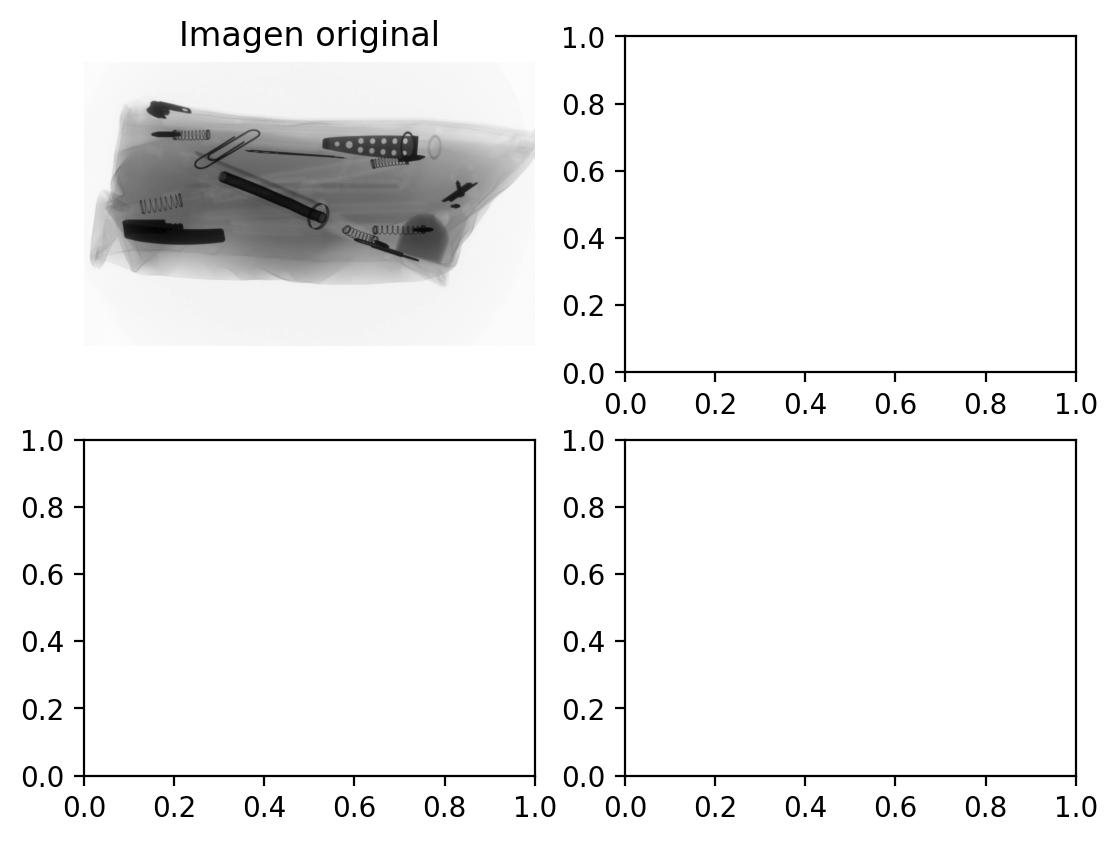

In [69]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(img_pencilcase, cmap='gray')
axs[0, 0].set_title('Imagen original')
axs[0, 0].axis('off')

axs[0, 1].imshow(edges, cmap='gray')
axs[0, 1].set_title('Bordes')
axs[0, 1].axis('off')

axs[1, 0].imshow(label_regions, cmap='gray')
axs[1, 0].set_title('Segmentación')
axs[1, 0].axis('off')

axs[1, 1].imshow(img_pencilcase, cmap='gray')
for b, bbox in enumerate(bboxes):
    rect = plt.Rectangle((bbox[0], bbox[1]),
                         bbox[2], bbox[3],
                         fill=False, edgecolor='royalblue')
    axs[1, 1].add_patch(rect)
axs[1, 1].set_title('Bounding boxes')
axs[1, 1].axis('off');

El algoritmo encontró 10 objetos distintos, segmentándolos bastante bien. El único problema pareciera ser que algunos objetos quedaron juntos pero esto puede ser arreglado con un procesamiento posterior. Logramos obtener los bordes de cada objeto, identificarlos individualmente y obtener sus _bounding boxes_.

¡Puedes probar este código con otras fotos!

## Chequeo final

La siguiente función revisará si los valores están correctos corriendo los mismos chequeos que antes.

Recuerda presionar _Validate_ arriba para que la plataforma corra todos los tests.

importlib.reload(checker)
assert checker.check_all(img_tomato_gaussian, img_tomato_borders_log, img_tomato_borders_canny,
                         thresh_plane_otsu, img_text_thresh_global,
                         img_text_thresh_mean, img_text_thresh_gaussian, img_text_thresh_adaptive)